In [1]:
import grpc
import swoq_pb2
import swoq_pb2_grpc
import numpy as np
from time import sleep
from map_util import *

In [2]:
player_id = '6616b1c5bd0a697480a68319'

In [3]:
def update_global_state(state):
    global map, visibility_range
    global player_pos, inventory, finished

    player_pos = (state.playerPos.y, state.playerPos.x)
    inventory = state.inventory
    finished = state.finished
    print(f'{player_pos=}, {inventory=}, {finished=}')

    top = player_pos[0] - visibility_range
    left = player_pos[1] - visibility_range
    i = 0
    for y in range(visibility_range*2 + 1):
        for x in range(visibility_range*2 + 1):
            s = state.surroundings[i]
            if s != UNKNOWN:
                map_x = left + x
                map_y = top + y
                if 0 <= map_y < map.shape[0] and 0 <= map_x < map.shape[1]:
                    map[map_y, map_x] = s
            i += 1

startResponse.result=0
game_id='d4c43a83-fb23-42fc-bcc4-7440b93fc82b', height=20, width=20, visibility_range=5
player_pos=(1, 1), inventory=0, finished=False


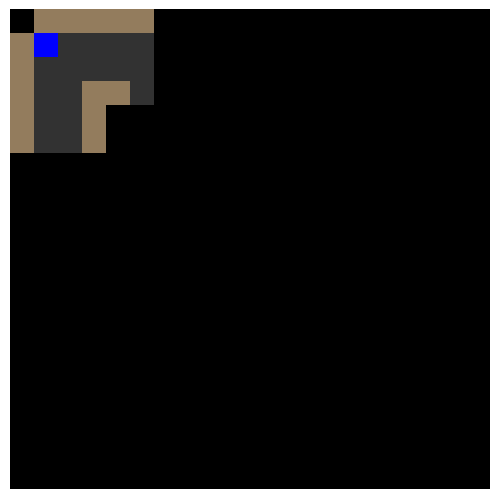

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x21e0be038c0>)

In [4]:
def start():
    global map, game_id, visibility_range
    
    with grpc.insecure_channel('localhost:5009') as channel:
        stub = swoq_pb2_grpc.TrainingStub(channel)
        startResponse = stub.StartGame(swoq_pb2.StartRequest(playerId=player_id, level=0))

    print(f'{startResponse.result=}')

    game_id = startResponse.gameId
    height = startResponse.height
    width = startResponse.width
    visibility_range = startResponse.visibilityRange
    print(f'{game_id=}, {height=}, {width=}, {visibility_range=}')

    map = np.zeros((height, width), dtype=np.int8)

    update_global_state(startResponse.state)

start()
plot_map(map)

In [5]:
def softmax(a):
    e = np.exp(a)
    return e / np.sum(e)

def pick_random_move(map):
    height, width = map.shape
    player_pos = np.unravel_index(np.argwhere(map == 2).flatten()[0], (height, width))
    target_pos = np.array([height-2, width-1])
    print(f'{player_pos=}, {target_pos=}')

    diff = target_pos - player_pos
    direction = np.sign(diff)

    # increase probability for actions in right direction
    moves = np.ones((4,))
    if direction[0] < 0: moves[0] += 1 # NORTH
    if direction[0] > 0: moves[1] += 1 # SOUTH
    if direction[1] < 0: moves[2] += 1 # WEST
    if direction[1] > 0: moves[3] += 1 # EAST
    print(f'{moves=}')
    moves = softmax(moves)

    # choose random move
    directions = [swoq_pb2.NORTH, swoq_pb2.SOUTH, swoq_pb2.WEST, swoq_pb2.EAST]
    direction = np.random.choice(directions, p=moves)
    print(f'{direction=}')
    return direction

In [6]:
to_swoq_pb2_direction = {
    'N': swoq_pb2.NORTH,
    'E': swoq_pb2.EAST,
    'S': swoq_pb2.SOUTH,
    'W': swoq_pb2.WEST,
    None: None,
}
def move(direction: str) -> None:
    global frame, to_swoq_pb2_direction
    
    dir = to_swoq_pb2_direction[direction]
    
    with grpc.insecure_channel('localhost:5009') as channel:
        stub = swoq_pb2_grpc.TrainingStub(channel)
        moveResponse = stub.Move(swoq_pb2.ActionRequest(gameId=game_id, direction=dir))

    if moveResponse.result == 0:
        update_global_state(moveResponse.state)

    update_map(frame, map)
    print(f'{moveResponse.result=}')
    print(f'{moveResponse.state.finished=}')
    print(f'{moveResponse.state.inventory=}')

def use(direction: str) -> None:
    global frame, to_swoq_pb2_direction

    dir = to_swoq_pb2_direction[direction]

    with grpc.insecure_channel('localhost:5009') as channel:
        stub = swoq_pb2_grpc.TrainingStub(channel)
        useResponse = stub.Use(swoq_pb2.ActionRequest(gameId=game_id, direction=dir))

    if useResponse.result == 0:
        update_global_state(useResponse.state)
        
    update_map(frame, map)
    print(f'{useResponse.result=}')
    print(f'{useResponse.state.finished=}')
    print(f'{useResponse.state.inventory=}')

In [7]:
def get_direction_towards_closest_unknown():
    global map, player_pos

    distances, paths = compute_distances(map, player_pos)

    closest_empty = None
    closest_dist = None

    # find closest empty with UNKNOWN neighbors
    for pos in np.argwhere(map == EMPTY):
        pos = tuple(pos)
        pos_y, pos_x = pos
        if map[pos_y, pos_x-1] == UNKNOWN or \
                map[pos_y, pos_x+1] == UNKNOWN or \
                map[pos_y+1, pos_x] == UNKNOWN or \
                map[pos_y-1, pos_x] == UNKNOWN:
            dist = distances[pos]
            if closest_dist is None or dist < closest_dist:
                closest_dist = dist
                closest_empty = pos
               
    if closest_empty is None:
        return None

    return get_direction_towards(paths, player_pos, closest_empty)

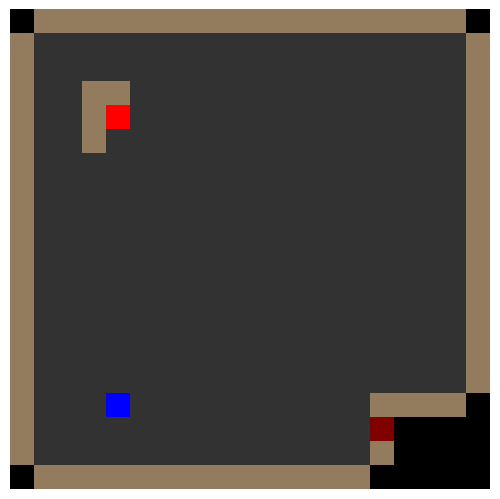

moveResponse.result=0
moveResponse.state.finished=False
moveResponse.state.inventory=0


In [8]:

def explore():
    while True:
        direction = get_direction_towards_closest_unknown()
        if direction is None: break
        move(direction)
        #sleep(0.05)

frame = plot_map(map)
explore()

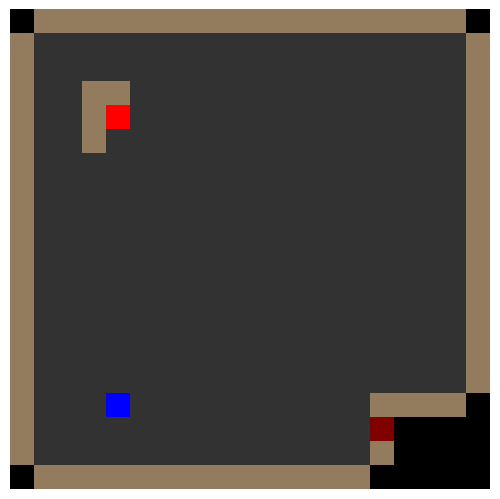

In [9]:
def try_reach_exit():
    global map
    
    exit_pos = np.argwhere(map == EXIT)
    if not np.any(exit_pos): return
    
    exit_pos = exit_pos[0]
    while True:
        direction = get_direction_from_towards(map, player_pos, tuple(exit_pos))
        if direction is None: break
        move(direction)

frame = plot_map(map)
try_reach_exit()

In [10]:
def move_to_target(target_pos: tuple[int, int]) -> None:
    global map, player_pos
    while True:
        direction = get_direction_from_towards(map, player_pos, target_pos)
        if direction is None: break
        move(direction)

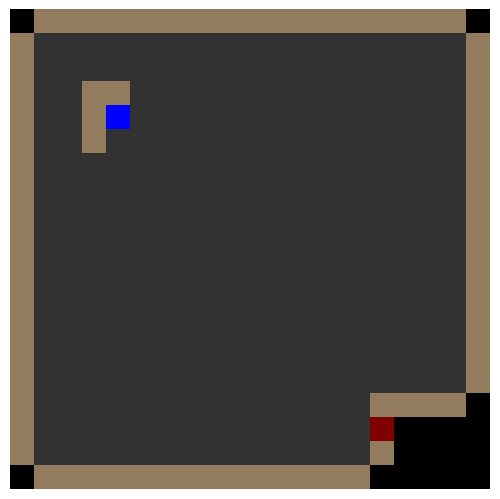

moveResponse.result=0
moveResponse.state.finished=False
moveResponse.state.inventory=1


In [11]:
def try_get_key():
    global map, inventory
    
    if inventory != INVENTORY_NONE: return

    target_pos = None
    
    doors = np.argwhere(map == DOOR_RED)
    keys = np.argwhere(map == KEY_RED)
    if target_pos is None and np.any(doors) and np.any(keys):
        target_pos = tuple(keys[0])

    doors = np.argwhere(map == DOOR_GREEN)
    keys = np.argwhere(map == KEY_GREEN)
    if target_pos is None and np.any(doors) and np.any(keys):
        target_pos = tuple(keys[0])

    doors = np.argwhere(map == DOOR_BLUE)
    keys = np.argwhere(map == KEY_BLUE)
    if target_pos is None and np.any(doors) and np.any(keys):
        target_pos = tuple(keys[0])

    if target_pos is not None:
        move_to_target(target_pos)

frame = plot_map(map)
try_get_key()

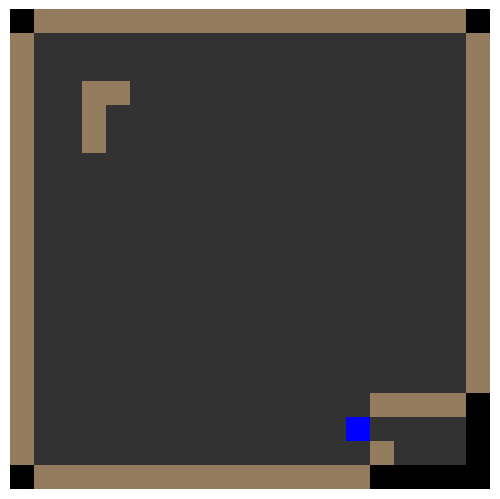

useResponse.result=0
useResponse.state.finished=False
useResponse.state.inventory=0


In [12]:
def try_open_door():
    global map, inventory
    
    target_pos = None
    use_direction = None
    
    def find_target(door):
        nonlocal target_pos, use_direction
        global map
        
        top = (door[0]-1, door[1])
        if target_pos is None and map[top[0], top[1]] == EMPTY:
            target_pos = top
            use_direction = 'S'
        bottom = (door[0]+1, door[1])
        if target_pos is None and map[bottom[0], bottom[1]] == EMPTY:
            target_pos = bottom
            use_direction = 'N'
        left = (door[0], door[1]-1)
        if target_pos is None and map[left[0], left[1]] == EMPTY:
            target_pos = left
            use_direction = 'E'
        right = (door[0], door[1]+1)
        if target_pos is None and map[right[0], right[1]] == EMPTY:
            target_pos = right
            use_direction = 'W'
    
    if target_pos is None and inventory == INVENTORY_KEY_RED:
        doors = np.argwhere(map == DOOR_RED)
        if np.any(doors): find_target(doors[0])

    if target_pos is None and inventory == INVENTORY_KEY_GREEN:
        doors = np.argwhere(map == DOOR_GREEN)
        if np.any(doors): find_target(doors[0])

    if target_pos is None and inventory == INVENTORY_KEY_BLUE:
        doors = np.argwhere(map == DOOR_BLUE)
        if np.any(doors): find_target(doors[0])
                
    if target_pos is not None:
        move_to_target(target_pos)
        use(use_direction)
            
frame = plot_map(map)
try_open_door()

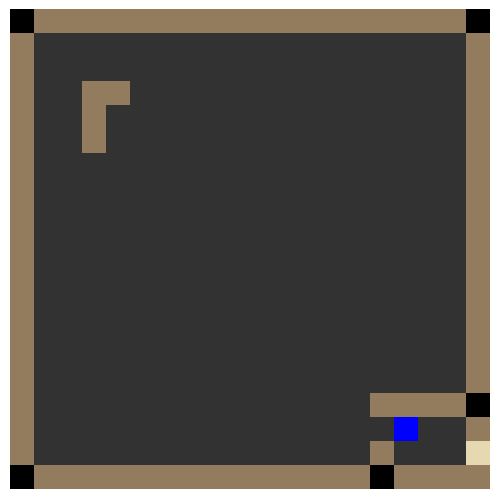

moveResponse.result=0
moveResponse.state.finished=False
moveResponse.state.inventory=0


In [13]:
frame = plot_map(map)
explore()

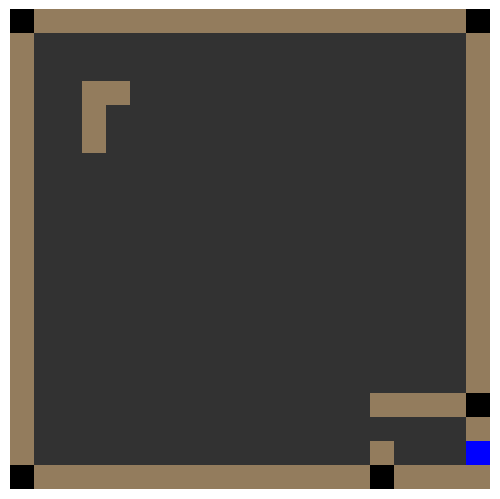

moveResponse.result=0
moveResponse.state.finished=True
moveResponse.state.inventory=0


In [14]:
start()
frame = plot_map(map)

while not finished:
    explore()
    try_reach_exit()
    if finished: break
    try_get_key()
    try_open_door()